In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from tqdm.notebook import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from xfeat.helper import aggregation
import category_encoders as ce
import joblib

pd.options.display.max_columns = 500

In [2]:
import sklearn, xfeat
for library in [np, pd, lgb, sklearn, xfeat, ce, joblib]:
    print(f'{library.__name__} {library.__version__}')

numpy 1.19.2
pandas 1.1.3
lightgbm 3.1.0
sklearn 0.23.2
xfeat 0.1.0
category_encoders 2.2.2
joblib 0.17.0


In [3]:
def read_data():
    train = pd.read_csv('../data/train.csv')
    test = pd.read_csv('../data/test.csv')
    return train, test

train, test = read_data()

In [4]:
targets = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity',
           'clean_cup', 'sweetness', 'cupper_points', 'total_cup_points']
groups = train['farm_name']
train.drop('farm_name', axis=1, inplace=True)
test.drop('farm_name', axis=1, inplace=True)

In [5]:
def target_encoding(X_train, y_train, X_test, col_name, replace=True):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    # テストデータのカテゴリを変換する
    Xy = pd.DataFrame({'trans_col': X_train[col_name], 'target': y_train})
    target_mean_all = Xy.groupby('trans_col')['target'].mean()
    if replace:
        X_test[col_name] = X_test[col_name].map(target_mean_all)
    else:
        X_test[f'te_{col_name}'] = X_test[col_name].map(target_mean_all)

    # trainを変換する
    oof_target = np.zeros(X_train.shape[0])
    kf = GroupKFold(n_splits=5)
    for idx_1, idx_2 in kf.split(X_train, groups=groups):
        target_mean = Xy.iloc[idx_1, :].groupby('trans_col')['target'].mean()
        oof_target[idx_2] = X_train[col_name].iloc[idx_2].map(target_mean)
    
    if replace:
        X_train[col_name] = oof_target
    else:
        X_train[f'te_{col_name}'] = oof_target
    
    return X_train, X_test

In [6]:
# ref: https://www.guruguru.science/competitions/15/discussions/559b789a-3196-40cf-9d14-cb5b6495308f/
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()
        
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None

    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])

    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")
    
def get_ce_features(input_df):
    _input_df = pd.concat([
        input_df,
        get_defects_features(input_df),
    ], axis=1)

    cols = [
        "species",
        "owner",
        "countryof_origin",
        "mill", 
        "company",
        "region", 
        "producer",
        "in_country_partner", 
        "owner1",
        "variety",
        "processing_method", 
        "color",
        "unit_of_measurement",
        "category_one_defects_raw",
        "category_two_defects_raw",
        "category_one_and_two_defects_raw",
    ]
    encoder = CountEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df

def get_num_bags_feature(input_df):
    output_df = pd.DataFrame()
    output_df["numberof_bags_raw"] = input_df["numberof_bags"]
    tmp = [t.zfill(3) for t in input_df["numberof_bags"].astype(str)]
    output_df["numberof_bags_100"] = [int(t[0]) for t in tmp] 
    output_df["numberof_bags_010"] = [int(t[1]) for t in tmp] 
    output_df["numberof_bags_001"] = [int(t[2]) for t in tmp] 
    return output_df

def get_bag_weight_features(input_df):
    output_df = pd.DataFrame()
    tmp = input_df['bag_weight'].str.extract(r'(\d*)\s*([a-zA-Z]*)')
    tmp.columns = ['bag_weight_value', 'bag_weight_unit']
    tmp["bag_weight_value"] = tmp["bag_weight_value"].astype(int)
    tmp.loc[tmp["bag_weight_unit"] == "kg", 'bag_weight_value'] = tmp["bag_weight_value"][tmp["bag_weight_unit"] == "kg"] * 1000
    tmp.loc[tmp["bag_weight_unit"] == "lbs", 'bag_weight_value'] = tmp["bag_weight_value"][tmp["bag_weight_unit"] == "lbs"] * 453
    tmp.loc[tmp["bag_weight_unit"] == "", 'bag_weight_value'] = tmp["bag_weight_value"][tmp["bag_weight_unit"] == ""] * 1000
    output_df["bag_weight_g"] = tmp["bag_weight_value"]
    output_df["bag_weight_log_g"] = np.log1p(output_df["bag_weight_g"])
    return output_df

def get_hervest_year_features(input_df):
    # help me
    key_year = ['2012','2014','2013','2015','2016',
       '2017','2013/2014','2015/2016','2011','2017 / 2018',
       '2014/2015','2009/2010','2010','2010-2011','2016 / 2017',
       '4T/10','Mayo a Julio','March 2010','4T/2010','2009-2010',
       '08/09 crop','2011/2012','January 2011','Abril - Julio','May-August',
       '2016/2017','4T72010','Sept 2009 - April 2010','August to December','23 July 2010',
       '2009 - 2010','4t/2010','1t/2011','2009 / 2010','Spring 2011 in Colombia.',
       'TEST','mmm','4t/2011','47/2010','December 2009-March 2010',
       '3T/2011','Abril - Julio /2011','1T/2011','2018','January Through April','Fall 2009']
    val_year = [2012, 2014, 2013, 2015, 2016, 2017, 2013, 
       2015, 2011, 2017, 2014, 2009,
       2010, 2010, 2016, 2010, np.nan,
       2010, 2010, 2009, np.nan, 2011, 
       2011, np.nan, np.nan, 2016, 
       2010, 2009, np.nan, 
       2010, 2009, 2010,2011, 2009, 
       2011, np.nan, np.nan, 2011, 2010,
       2009, 2011, 2011,
       2011, 2018, np.nan, 2009]
    dic_df = pd.DataFrame()
    dic_df["key_year"] = key_year
    dic_df["val_year"] = val_year
    # print(dic_df)

    output_df = pd.DataFrame()
    harvest_year_dic = dict(zip(dic_df["key_year"], dic_df["val_year"]))
    output_df["harvest_year"] = input_df["harvest_year"].map(harvest_year_dic)
    return output_df

def get_altitude_features(input_df):
    cols = [
        "altitude_low_meters",
        "altitude_high_meters",
        "altitude_mean_meters",
    ]
    return input_df[cols].copy()

def get_grading_date_features(input_df):
    output_df = pd.DataFrame()
    tmp = pd.to_datetime(input_df["grading_date"])
    output_df["grading_date_julian"] = tmp.map(pd.Timestamp.to_julian_date)
    output_df["grading_date_year"] = tmp.dt.year
    output_df["grading_date_month"] = tmp.dt.month
    output_df["grading_date_day"] = tmp.dt.day
    tmp_raw = output_df["grading_date_year"].astype(str) + output_df["grading_date_month"].astype(str) + output_df["grading_date_day"].astype(str)
    output_df["grading_date_raw"] = tmp_raw.astype(int)
    return output_df

def get_expiration_features(input_df):
    output_df = pd.DataFrame()
    tmp = pd.to_datetime(input_df["expiration"])
    output_df["expiration_julian"] = tmp.map(pd.Timestamp.to_julian_date)
    output_df["expiration_year"] = tmp.dt.year
    output_df["expiration_month"] = tmp.dt.month
    output_df["expiration_day"] = tmp.dt.day
    tmp_raw = output_df["expiration_year"].astype(str) + output_df["expiration_month"].astype(str) + output_df["expiration_day"].astype(str)
    output_df["expiration_raw"] = tmp_raw.astype(int)
    return output_df

def get_moisture_features(input_df):
    output_df = pd.DataFrame()
    tmp = input_df["moisture"]
    output_df["moisture_raw"] = tmp
    output_df["moisture_010"] = [int(str(t)[2]) for t in tmp]
    return output_df

def get_defects_features(input_df):
    output_df = pd.DataFrame()
    _df = input_df[["category_one_defects", "category_two_defects"]].astype(str)
    output_df["category_one_defects_raw"] = _df["category_one_defects"]
    output_df["category_two_defects_raw"] = _df["category_two_defects"]
    output_df["category_one_and_two_defects_raw"] = _df["category_one_defects"] + _df["category_two_defects"]
    output_df = ce.OrdinalEncoder().fit_transform(output_df)
    return output_df

def get_cross_num_features(input_df):
    _input_df = pd.concat([
        get_grading_date_features(input_df),
        get_expiration_features(input_df),
        get_hervest_year_features(input_df),
        get_num_bags_feature(input_df),
        get_bag_weight_features(input_df),
        get_moisture_features(input_df),
        get_altitude_features(input_df),
    ], axis=1)

    output_df = pd.DataFrame()
    output_df["diff_hervest_grading_year"] = _input_df["harvest_year"] - _input_df["grading_date_year"]
    output_df["diff_hervest_expiration_year"] = _input_df["harvest_year"] - _input_df["expiration_year"]
    output_df["diff_grading_expiration_year"] = _input_df["grading_date_year"] - _input_df["expiration_year"]
    output_df["diff_grading_expiration_day"] = _input_df["grading_date_day"] - _input_df["expiration_day"]
    output_df["diff_grading_expiration_julian"] = _input_df["grading_date_julian"] - _input_df["expiration_julian"]
    output_df["prod_grading_expiration_day"] = _input_df["grading_date_day"] * _input_df["expiration_day"]
    output_df["prod_numBags_bagWeight"] = _input_df["numberof_bags_raw"] * _input_df["bag_weight_g"]
    output_df["prod_numBags_logBagWeight"] = _input_df["numberof_bags_raw"] * _input_df["bag_weight_log_g"]
    output_df["prod_moisture_altitudeMean"] = _input_df["moisture_raw"] * _input_df["altitude_mean_meters"]
    return output_df

def to_features(train, test):
    input_df = pd.concat([train, test]).reset_index(drop=True)

    processes = [
        get_ce_features,
        get_num_bags_feature,
        get_bag_weight_features,
        get_hervest_year_features,
        get_grading_date_features,
        get_expiration_features,
        get_moisture_features,
        # get_defects_features,
        get_cross_num_features,
        #agg_company,
        #agg_region,
    ]

    output_df = pd.DataFrame()
    for func in tqdm(processes):
        _df = func(input_df)
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    train_x = output_df.iloc[:len(train)] 
    test_x = output_df.iloc[len(train):].reset_index(drop=True)
    return train_x, test_x

In [7]:
X_train, X_test = to_features(train, test)

In [8]:
train = pd.concat([train.drop('harvest_year', axis=1), X_train], axis=1)
test = pd.concat([test.drop('harvest_year', axis=1), X_test], axis=1)

In [9]:
cat_cols = ['species', 'owner', 'countryof_origin', 'lot_number', 'mill',
       'ico_number', 'company', 'altitude', 'region', 'producer',
       'bag_weight', 'in_country_partner',
       'grading_date', 'owner1', 'variety', 'processing_method', 
        'color', 'expiration', 'unit_of_measurement']

In [10]:
for target in tqdm(targets):
    for cat_col in cat_cols:
        train, test = target_encoding(train, train[target].copy(), test, cat_col, replace=False)

In [11]:
num_cols = [
 'altitude_high_meters',
 'altitude_low_meters',
 'altitude_mean_meters',
 'bag_weight_g',
 'bag_weight_log_g',
 'category_one_defects',
 'category_two_defects',
 'diff_grading_expiration_day',
 'diff_grading_expiration_julian',
 'diff_grading_expiration_year',
 'diff_hervest_expiration_year',
 'diff_hervest_grading_year',
 'expiration_day',
 'expiration_julian',
 'expiration_month',
 'expiration_raw',
 'expiration_year',
 'grading_date_day',
 'grading_date_julian',
 'grading_date_month',
 'grading_date_raw',
 'grading_date_year',
 'harvest_year',
 'moisture',
 'moisture_010',
 'moisture_raw',
 'numberof_bags',
 'numberof_bags_001',
 'numberof_bags_010',
 'numberof_bags_100',
 'numberof_bags_raw',
 'prod_grading_expiration_day',
 'prod_moisture_altitudeMean',
 'prod_numBags_bagWeight',
 'prod_numBags_logBagWeight',
 'quakers'
]
whole_df = pd.concat([train, test], axis=0).reset_index(drop=True)
for cat_col in tqdm(cat_cols):
    whole_df, _ = aggregation(whole_df, cat_col, num_cols, agg_methods=['mean', 'min', 'max', 'std'])

In [12]:
train = whole_df.iloc[:len(train), :].reset_index(drop=True)
test = whole_df.iloc[len(train):, :].reset_index(drop=True).drop(targets, axis=1)

In [13]:
def train_lgb(X_train, y_train, X_test, groups):
    kf = GroupKFold(n_splits=5)
    oof = np.zeros(X_train.shape[0])
    y_pred = np.zeros(X_test.shape[0])
    
    X_train[cat_cols] = X_train[cat_cols].astype('category')
    X_test[cat_cols] = X_test[cat_cols].astype('category')
    
    models = []

    for i, (train_index, valid_index) in enumerate(kf.split(X_train, groups=groups)):
        print(f'Start {i+1} fold')
        print('-' * 20)
        X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        X_tes = X_test.copy()

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
        lgb_params = {
            'objective': 'mae',
            'metric': 'mae',
            'max_depth': 3,
            'num_leaves': 2 ** 8,
            'learning_rate': 0.01,
            'bagging_fraction': 0.8,
            'feature_fraction': 0.1,
            'random_state': 0,
            'verbosity': -1
            }
        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=(lgb_train, lgb_valid),
            num_boost_round=100000000,
            early_stopping_rounds=300,
            verbose_eval=1000
        )
        models.append(model)
        oof[valid_index] = model.predict(X_val)
        y_pred += model.predict(X_tes) / 5
    
    return oof, y_pred, models

In [14]:
oof_df = pd.DataFrame()
y_pred_df = pd.DataFrame()
all_models = []

for target in tqdm(targets):
    print(f'start {target} {"-" * 10}')
    y_train = train[target].copy()
    X_train = train.drop(targets, axis=1)
    oof, y_pred, models = train_lgb(X_train, y_train, test, groups)
    oof_df[target] = oof
    y_pred_df[target] = y_pred
    all_models.append(models)

start aroma ----------
Start 1 fold
--------------------


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[268]	training's l1: 5.45893	valid_1's l1: 7.17749
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.41581	valid_1's l1: 5.81136
[2000]	training's l1: 4.00888	valid_1's l1: 5.76421
Early stopping, best iteration is:
[2056]	training's l1: 3.99878	valid_1's l1: 5.76307
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.25204	valid_1's l1: 7.26381
[2000]	training's l1: 3.85437	valid_1's l1: 7.16633
[3000]	training's l1: 3.66209	valid_1's l1: 7.14708
[4000]	training's l1: 3.51902	valid_1's l1: 7.12024
[5000]	training's l1: 3.4269	valid_1's l1: 7.11
[6000]	training's l1: 3.35398	valid_1's l1: 7.09432
Early stopping, best iteration is:
[6598]	training's l1: 3.31683	valid_1's l1: 7.07828
Start 4 fold
--------------------
Training until validation scores don't i

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[562]	training's l1: 4.83442	valid_1's l1: 6.7601
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[689]	training's l1: 4.6978	valid_1's l1: 5.93616
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[349]	training's l1: 5.08767	valid_1's l1: 7.25698
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.52266	valid_1's l1: 7.26281
[2000]	training's l1: 4.12939	valid_1's l1: 7.20097
Early stopping, best iteration is:
[2471]	training's l1: 4.00877	valid_1's l1: 7.18614
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.49481	valid_1's l1: 6.67045
[2000]	training's l1: 4.09906	valid_1's l1: 6.59527
[30

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.42372	valid_1's l1: 6.72175
Early stopping, best iteration is:
[773]	training's l1: 4.63647	valid_1's l1: 6.69308
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.29909	valid_1's l1: 6.47312
Early stopping, best iteration is:
[1341]	training's l1: 4.08499	valid_1's l1: 6.46326
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.30979	valid_1's l1: 7.49392
Early stopping, best iteration is:
[802]	training's l1: 4.46773	valid_1's l1: 7.49061
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.4083	valid_1's l1: 7.13897
Early stopping, best iteration is:
[1580]	training's l1: 4.12864	valid_1's l1: 7.11469
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
[

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.35048	valid_1's l1: 7.06266
Early stopping, best iteration is:
[1349]	training's l1: 4.12007	valid_1's l1: 7.03976
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[406]	training's l1: 5.27181	valid_1's l1: 5.78772
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.16631	valid_1's l1: 7.91848
Early stopping, best iteration is:
[1363]	training's l1: 3.97734	valid_1's l1: 7.89746
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.34259	valid_1's l1: 6.78545
[2000]	training's l1: 3.93819	valid_1's l1: 6.73141
[3000]	training's l1: 3.73448	valid_1's l1: 6.70764
[4000]	training's l1: 3.60752	valid_1's l1: 6.66924
Early stopping, best iteration is:
[4321]	training's l1: 3.57084	valid_1's l1:

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.57275	valid_1's l1: 6.39641
[2000]	training's l1: 4.11411	valid_1's l1: 6.35684
Early stopping, best iteration is:
[2685]	training's l1: 3.97667	valid_1's l1: 6.33103
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.36074	valid_1's l1: 6.23242
Early stopping, best iteration is:
[1191]	training's l1: 4.23672	valid_1's l1: 6.22625
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[169]	training's l1: 5.73772	valid_1's l1: 7.31925
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.39183	valid_1's l1: 7.20588
Early stopping, best iteration is:
[1454]	training's l1: 4.1531	valid_1's l1: 7.18823
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.30072	valid_1's l1: 6.40289
Early stopping, best iteration is:
[1543]	training's l1: 4.01021	valid_1's l1: 6.38895
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[458]	training's l1: 4.92082	valid_1's l1: 6.13063
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[338]	training's l1: 5.07392	valid_1's l1: 6.76248
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.38804	valid_1's l1: 6.43722
Early stopping, best iteration is:
[892]	training's l1: 4.46532	valid_1's l1: 6.43311
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.34016	valid_1's l1: 6.37154
[2000]	training's l1: 3.88458	valid_1's l1: 6.25823
[

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 8.60199	valid_1's l1: 9.15674
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 9.11178	valid_1's l1: 7.11556
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 8.73218	valid_1's l1: 8.62701
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 8.52838	valid_1's l1: 9.4551
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[5]	training's l1: 8.57897	valid_1's l1: 9.21866
start clean_cup ----------
Start 1 fold
--------------------


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.33796	valid_1's l1: 6.85591
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.42062	valid_1's l1: 6.52663
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.78106	valid_1's l1: 5.08705
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.57499	valid_1's l1: 5.91364
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 6.09748	valid_1's l1: 3.81783
start sweetness ----------
Start 1 fold
--------------------


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[3]	training's l1: 5.96912	valid_1's l1: 5.28858
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 6.15872	valid_1's l1: 4.66716
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[491]	training's l1: 4.18048	valid_1's l1: 4.07112
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1]	training's l1: 5.43066	valid_1's l1: 7.5429
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[5]	training's l1: 5.46045	valid_1's l1: 7.42707
start cupper_points ----------
Start 1 fold
--------------------


/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[516]	training's l1: 4.8579	valid_1's l1: 6.53569
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[535]	training's l1: 4.76714	valid_1's l1: 6.34021
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.34015	valid_1's l1: 6.8476
[2000]	training's l1: 3.96595	valid_1's l1: 6.82214
[3000]	training's l1: 3.74668	valid_1's l1: 6.79637
Early stopping, best iteration is:
[3314]	training's l1: 3.68981	valid_1's l1: 6.78638
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.41177	valid_1's l1: 6.83969
[2000]	training's l1: 4.0132	valid_1's l1: 6.75238
[3000]	training's l1: 3.80218	valid_1's l1: 6.72488
[4000]	training's l1: 3.69483	valid_1's l1: 6.69367
Early stopping, best iteration

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/nekoumei/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.21783	valid_1's l1: 6.88124
Early stopping, best iteration is:
[919]	training's l1: 4.27738	valid_1's l1: 6.87308
Start 2 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[539]	training's l1: 4.90703	valid_1's l1: 5.55208
Start 3 fold
--------------------
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[617]	training's l1: 4.48103	valid_1's l1: 7.26019
Start 4 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1000]	training's l1: 4.39682	valid_1's l1: 6.76289
[2000]	training's l1: 3.95439	valid_1's l1: 6.6528
[3000]	training's l1: 3.69449	valid_1's l1: 6.61412
Early stopping, best iteration is:
[2977]	training's l1: 3.69742	valid_1's l1: 6.61324
Start 5 fold
--------------------
Training until validation scores don't improve for 300 rounds
[1

In [15]:
oof_df = np.clip(oof_df, 0, 100)
y_pred_df = np.clip(y_pred_df, 0, 100)

In [16]:
mean_absolute_error(train[targets], oof_df)

6.628326748906863

In [17]:
joblib.dump((train, test, cat_cols, groups), '../data/features.joblib')

['../data/features.joblib']

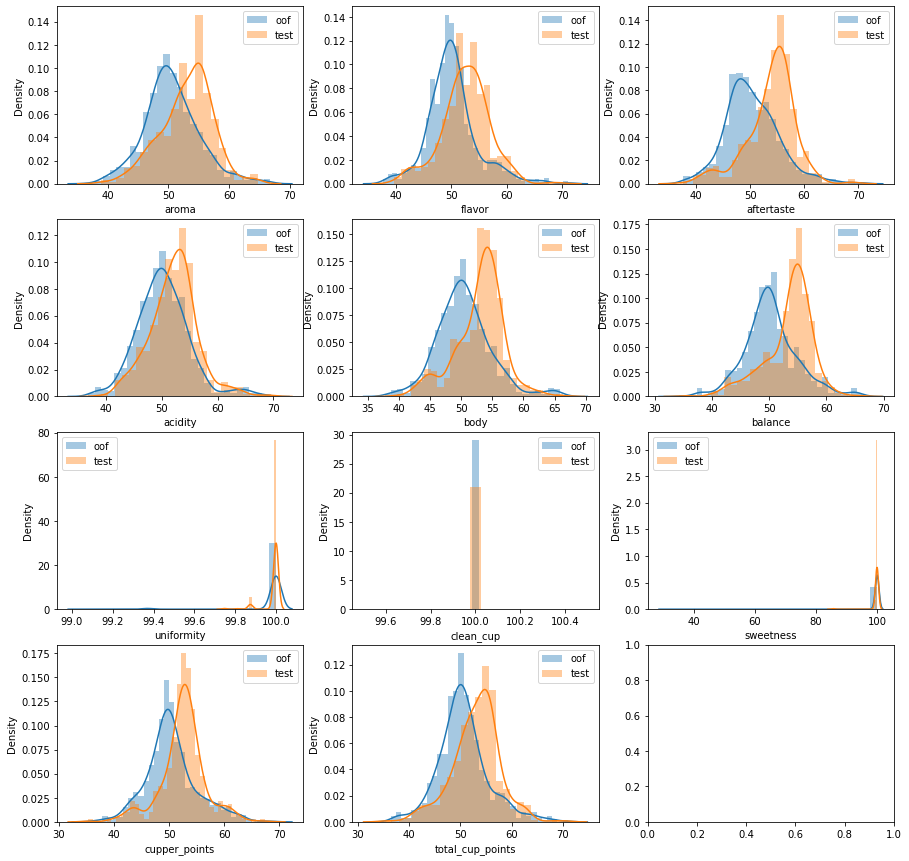

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

i = 0
for ax_row in axs:
    for ax in ax_row:
        target = targets[i]
        #sns.distplot(train[target], ax=ax, label='y_true')
        sns.distplot(oof_df[target], ax=ax, label='oof')
        sns.distplot(y_pred_df[target], ax=ax, label='test')
        ax.legend()
        i += 1
        if i > 10:
            break

In [19]:
y_pred_df.to_csv('../output/sub_gkf.csv', index=False)